# Predicting depression through social media

In [1]:
%matplotlib inline
from pyspark.context import SparkContext
import datetime
from os import path
from PIL import Image
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import re
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)


In [2]:
sc = SparkContext.getOrCreate()

truePositivesPath = "../truepositives.csv"
trueNegativesPath = "../truenegatives.csv"

## Helper Functions

In [3]:
def isTimeStamp(date_text):
    if date_text is None: 
        return False
    try:
        datetime.datetime.strptime(date_text, '%Y-%m-%d %H:%M:%S')
        return True
    except ValueError, TypeError:
        return False

In [4]:
def make_word_cloud(mask_file_path, text, title):
    """This method creates a word cloud based on the word count from the given text."""
    d = path.dirname(".")
    mask_image = np.array(Image.open(path.join(d, mask_file_path)))
    stopwords = set(STOPWORDS)
    stopwords.add("said")
    stopwords.add("https")
    stopwords.add("co")
    stopwords.add("amp")
    stopwords.add("RT")

    wc = WordCloud(background_color="white", max_words=2000, mask=mask_image, stopwords=stopwords)
    # generate word cloud
    wc.generate(text)

    # store to file
    wc.to_file(path.join(d, title+".png"))
    
    # show
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.figure()
    plt.show() 

## Creating a word cloud 

In [5]:
tp_dataframe = spark.read.options(header="true", parserLib="univocity").csv(truePositivesPath)

tn_dataframe = spark.read.options(header="true", parserLib="univocity").csv(trueNegativesPath)

In [6]:
tp_rdd = tp_dataframe.rdd\
                     .map(list)\
                     .filter(lambda line: isTimeStamp(line[1]))\
                     .cache()
                     
tn_rdd = tn_dataframe.rdd\
                     .map(list)\
                     .filter(lambda line: isTimeStamp(line[1]))\
                     .cache()
                     
            
print tp_rdd.count()
print tn_rdd.count()

823226
844283


In [7]:
tp_text_rdd = tp_rdd.map(lambda line: [str(re.sub(r'[^\x00-\x7F]+',' ', line[-1]))]).cache()
tn_text_rdd = tn_rdd.map(lambda line: [str(re.sub(r'[^\x00-\x7F]+',' ', line[-1]))]).cache()

tp_text_rdd.take(5)
tn_text_rdd.take(5)


[['@PCTPCY dances'],
 ['@PCTPCY kdkdkdkkdd'],
 ['we can dab together kekekeke https://t.co/WMsqICcGbF'],
 ['double snake bc   ok im lame'],
 ['  in korean means snake so bambam is a snake???']]

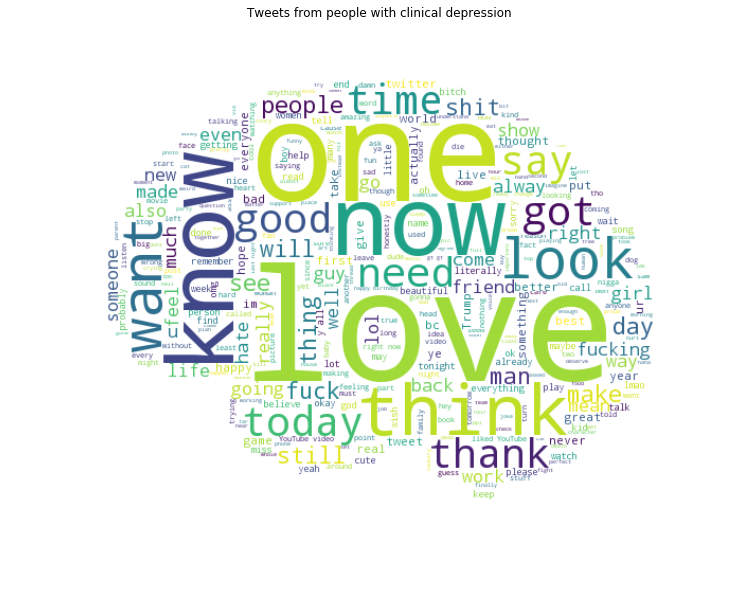

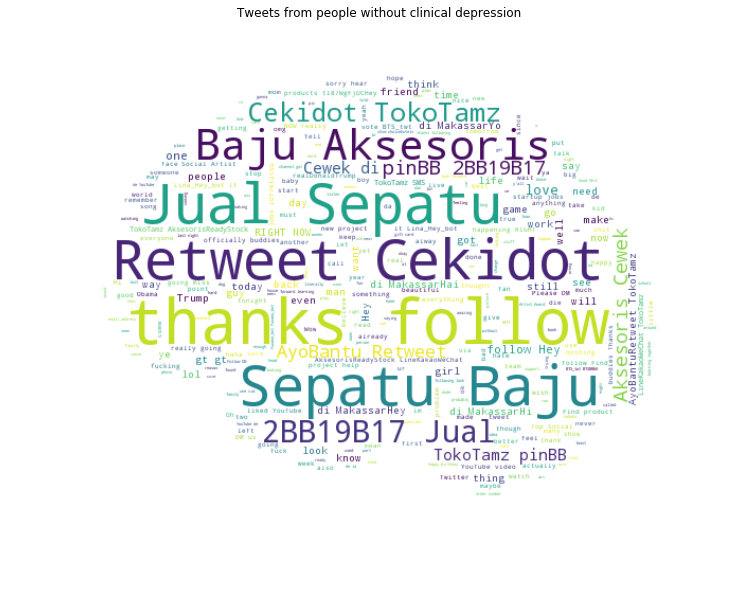

In [9]:
tp_collect = tp_text_rdd.collect()
tn_collect = tn_text_rdd.collect()

tp_text = ''.join(str(r) for v in tp_collect for r in v)
tn_text = ''.join(str(r) for v in tn_collect for r in v)

tp_title = "Tweets from people with clinical depression"
tn_title = "Tweets from people without clinical depression"
make_word_cloud("brain1.jpg", tp_text, tp_title)
make_word_cloud("brain1.jpg", tn_text, tn_title)

## Analyzing the data with TF-IDF

In [8]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml import Pipeline
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import CrossValidator

In [9]:
tp_label_text = tp_text_rdd.map(lambda line : [1, str(line)])
tn_label_text = tn_text_rdd.map(lambda line : [0, str(line)])

tweetRDD = tp_label_text.union(tn_label_text).collect()

tweetsDF = spark.createDataFrame(tweetRDD, ['label', 'tweet'])

splits = tweetsDF.randomSplit([0.6, 0.4])
training_df = splits[0]
test_df = splits[1]


In [10]:
tokenizer = Tokenizer(inputCol="tweet", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features")
idf = IDF(minDocFreq=3, inputCol="features", outputCol="idf")
nb = NaiveBayes()
pipeline = Pipeline(stages=[tokenizer, hashingTF, idf, nb])


paramGrid = ParamGridBuilder().addGrid(nb.smoothing, [0.0, 1.0]).build()


cv = CrossValidator(estimator=pipeline, 
                    estimatorParamMaps=paramGrid, 
                    evaluator=MulticlassClassificationEvaluator(), 
                    numFolds=4)

cvModel = cv.fit(training_df)

In [11]:
result = cvModel.transform(test_df)
prediction_df = result.select("tweet", "label", "prediction")

In [12]:
tpDF = prediction_df.filter(prediction_df['label']==1.0)
tpDF.show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------+-----+----------+
|tweet                                                                                                                                          |label|prediction|
+-----------------------------------------------------------------------------------------------------------------------------------------------+-----+----------+
|["     . Couldn't agree more."]                                                                                                                |1    |0.0       |
|["    im not happy but I hope you're happy,        "]                                                                                          |1    |0.0       |
|["   Journalists are all making the same joke about Theresa May's email "]                                                                     |1    |1.0       |
|["   You Should Be Li

In [13]:
tnDF = prediction_df.filter(prediction_df['label']==0.0)
tnDF.show(truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------+-----+----------+
|tweet                                                                                                                                           |label|prediction|
+------------------------------------------------------------------------------------------------------------------------------------------------+-----+----------+
|["  @spencerlist's twitter tomorrow."]                                                                                                          |0    |0.0       |
|[" @MattEngel_5: If you want something bad, you should work for it. Because everything won't be handed to you.  everything fails guys."]        |0    |1.0       |
|["#AskJJYeley What's your favorite thing to do when your not racing?"]                                                                          |0    |1.0       |
|["#Estonian Nat

In [14]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(result, {evaluator.metricName: "accuracy"})

0.741792019557148

In [15]:
from pyspark.ml.classification import LogisticRegression

lr = (LogisticRegression()).setMaxIter(1000).setRegParam(0.01)

lr_pipeline = Pipeline(stages=[tokenizer, hashingTF, idf, lr])

lr_paramGrid = ParamGridBuilder().addGrid(lr.regParam, [0.01, 0.1, 0.5,1.0, 2.0]).build()

lr_cv = CrossValidator(estimator=lr_pipeline, 
                    estimatorParamMaps=lr_paramGrid, 
                    evaluator=MulticlassClassificationEvaluator(), 
                    numFolds=4)


In [16]:
lr_cvModel = lr_cv.fit(training_df)

In [17]:
lr_result = lr_cvModel.transform(test_df)
lr_prediction_df = lr_result.select("tweet", "label", "prediction")

In [18]:
lr_tpDF = lr_prediction_df.filter(lr_prediction_df['label']==1.0)
lr_tpDF.show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------+-----+----------+
|tweet                                                                                                                                          |label|prediction|
+-----------------------------------------------------------------------------------------------------------------------------------------------+-----+----------+
|["     . Couldn't agree more."]                                                                                                                |1    |0.0       |
|["    im not happy but I hope you're happy,        "]                                                                                          |1    |0.0       |
|["   Journalists are all making the same joke about Theresa May's email "]                                                                     |1    |1.0       |
|["   You Should Be Li

In [19]:
lr_tnDF = lr_prediction_df.filter(lr_prediction_df['label']==0.0)
lr_tnDF.show(truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------+-----+----------+
|tweet                                                                                                                                           |label|prediction|
+------------------------------------------------------------------------------------------------------------------------------------------------+-----+----------+
|["  @spencerlist's twitter tomorrow."]                                                                                                          |0    |0.0       |
|[" @MattEngel_5: If you want something bad, you should work for it. Because everything won't be handed to you.  everything fails guys."]        |0    |0.0       |
|["#AskJJYeley What's your favorite thing to do when your not racing?"]                                                                          |0    |1.0       |
|["#Estonian Nat

In [20]:
lr_evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
lr_evaluator.evaluate(lr_result, {lr_evaluator.metricName: "accuracy"})

0.7583083426455477

In [31]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier()


dt_pipeline = Pipeline(stages=[tokenizer, hashingTF, idf, dt])
dt_paramGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [1,2,6,10])
             .addGrid(dt.maxBins, [20,40,80])
             .build())

dt_cv = CrossValidator(estimator=dt_pipeline, 
                    estimatorParamMaps=dt_paramGrid, 
                    evaluator=MulticlassClassificationEvaluator(), 
                    numFolds=4)

In [ ]:
dt_cvModel = dt_cv.fit(training_df)

print "numNodes = ", dt_cvModel.bestModel.numNodes
print "depth = ", dt_cvModel.bestModel.depth

In [ ]:
dt_result = dt_cvModel.transform(test_df)
dt_prediction_df = dt_result.select("tweet", "label", "prediction")

In [ ]:
dt_tpDF = dt_prediction_df.filter(dt_prediction_df['label']==1.0)
dt_tpDF.show(truncate=False)

In [ ]:
dt_tnDF = dt_prediction_df.filter(dt_prediction_df['label']==0.0)
dt_tnDF.show(truncate=False)

In [21]:
#from pyspark.ml.classification import MultilayerPerceptronClassifier
#layers = [4, 5, 4, 3]

#mlp = MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=128, seed=1234)

#mlp_pipeline = Pipeline(stages=[tokenizer, hashingTF, idf, mlp])

In [22]:
#mlp_model = mlp_pipeline.fit(training_df)

In [26]:
#mlp_result = mlp_model.transform(test_df)


In [ ]:
#mlp_prediction_df = mlp_result.select("tweet", "label", "prediction")
#mlp_prediction_df.show(truncate=False)

In [ ]:
#mlp_prediction_df = mlp_result.select("tweet", "label", "prediction")
#mlp_evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
#mlp_evaluator.evaluate(mlp_result, {mlp_evaluator.metricName: "accuracy"})